# Introduction to MSI, TensorFlow, PyTorch, NumPy, SciPy

## Outline
Below is a short introdcution some tools used in deep learning applications. We will go over
* Connecting and running jobs at MSI
* Using custom kernels in Jupyter
* Construction of a basic neural network with TensorFlow 
* Saving/Restoring models
* Basic example of PyTorch

http://z.umn.edu/colab-5980


# Introduction to MSI

### Connecting to MSI
- SSH from UMN network (including wireless and VPN)
```
ssh login.msi.umn.edu
ssh mesabi
```
- Jupyter (https://notebooks.msi.umn.edu/)

### Storage
- Home directory ~/
- Global scratch /scratch.global
- Local scratch /scratch.local
- S3 storage (s3.msi.umn.edu)
```
ssh login.msi.umn.edu
s3cmd ls 
s3cmd mb s3://$USER
s3cmd put some.file s3://$USER/some.file
```

### Software
- environment modules
 - used to control environment variables and prevent conflicts between the hundreds of installed software packages
```
module avail python
module load python/3.6.3
module unload python
```

### Compute Hardware
![MSI Servers](https://blynch.s3.msi.umn.edu/public/csci_5980_1_5.png)


- Mesabi (2015)
 - Cores: 19,040 Intel Haswell
 - Memory: 83 TB
 - Accelerators: 80 K40 Nvidia gpGPUs
 - Peak: 860 TFlops

- Mangi (2019 Mesabi upgrade) 
 - Cores: 20,888 AMD Rome
 - Memory: 56 TB
 - Accelerators: 40 Nvidia V100s
 - Peak: 1150 TFlops

- Mesabi+1 (2021)
 - Cores: ~40 k
 - Memory: ~180 TB
 - Accelerators: ~300 GPUs


## Singularity
- Run most containers on MSI resources without sudo permission
```
module load singularity
```

Singularity can be used to run most Docker containers. You can create a container on an Ubuntu laptop, transfer it to MSI, and then execute it using Singularity on the CentOS7 compute nodes.

**Note: you CAN NOT currently build singularity images on MSI login nodes**<br/>
You can
- create images elsewhere
- download from trusted sources
- remote build your continaers using the singularity public servers 
  - https://sylabs.io/

```
blynch@ln0006 [~/] cat test.spec
Bootstrap: docker
From: ubuntu:xenial-20191108

%post
apt-get update
apt-get upgrade -y

blynch@ln0006 [~/] singularity build --remote mytest.img test.spec
```

### Links
- [MSI Website](https://msi.umn.edu)
- [MSI YouTube Channel](https://www.youtube.com/channel/UCbdSk8D0_NP9BNbe2uXhV8Q)

# Batch Computing

1. Create a batch script
2. Submit script to a queue
3. Scheduler runs script at some point on the reosurces requested

A PBS submission script has 2 components
1. #PBS directives to tell the scheduler what resources you want
2. a set of commands to run

**An example script would look like:**

```
#!/usr/bin/bash
#PBS -l nodes=1:ppn=24
#PBS -l walltime=5:00:00
#PBS -l mem=60gb
#PBS -e myjob.e
#PBS -o myjob.o
#PBS -q mesabi

module load python
source activate myenvironment
cd some/directory
python something.py
```
**and can be submitted like:**

```
qsub myscript.sh
```


### Job Queues
https://www.msi.umn.edu/queues


# Interactive computing
- Jupyter (https://notebooks.msi.umn.edu)
- qsub <br>
From the command line:
```
ssh login.msi.umn.edu
ssh mesabi
qsub -l nodes=1:ppn=2,mem=2gb,walltime=1:00:00 -q interactive -I
```

The **interactive** queue is more available than other queues, but you can always request resources for interactive use. E.g.;
```
qsub -l nodes=1:ppn=24,gpus=2,walltime=1:00:00 -q k40 -I
```
or
```
qsub -l nodes=1:ppn=24,gpus=2,walltime=1:00:00 -q v100 -I
```


MSI will be transitioning to a new scheduler named Slurm very soon. For Slurm, the syntax will be:

```
srun -p interactive --pty bash
``` 

Additional information on the new scheduler can be found here:
https://www.msi.umn.edu/content/job-submission-and-scheduling-slurm

# Using Custom Kernels in Jupyter


1.   ssh into mesabi
2.   load python module
3.   create a new python environment
4.   customize environment



```
ssh login.msi.umn.edu
ssh mesabi

module load python
conda create -y --name myproject
source activate myproject
```

```
mkdir .local/share/jupyter/kernels/mynewkernel
vi .local/share/jupyter/kernels/mynewkernel/kernel.json
```

```
{
 "argv": [
  "/home/support/blynch/.conda/envs/mynewkernel/bin/python",
  "-m",
  "ipykernel_launcher",
  "-f",
  "{connection_file}"
 ],
 "display_name": "Python 3 - My Special Kernel",
 "language": "python"
}
```

customize your kernels
```
{
 "argv": [
  "/opt/singularity/singularity",
  "exec",
  "-B",
  "/panfs/roc/groups/2/support/blynch:/panfs/roc/groups/2/support/blynch",
  "/home/support/blynch/singularity/tf.simg",
  "/opt/anaconda3/bin/python",
  "-m",
  "ipykernel",
  "-f",
  "{connection_file}"
 ],
 "display_name": "Python 3.6 Singularity Tensorflow r1.12",
 "language": "python"
}
```

- Tensorflow as started by Google, released in November 2015
- Written in C++
- Typically used from within Python directly or through the Keras module in Python

# TensorFlow basics

1. Define a directed graph
2. execute

![alt text](https://upload.wikimedia.org/wikipedia/commons/f/fe/Tred-G.svg)







In [ ]:
import tensorflow as tf
x = tf.Variable(3, name="x")
y = tf.Variable(7, name="y")
f = x*100 + y*3 - 7
print(f)

# Keras
- developed as a high-level interface to create neural networks with Tensorflow and Theano.
- now it also supports Microsoft CNTK

![alt text]( https://blynch.s3.msi.umn.edu/public/csci_5980_1_6.png)

In [ ]:
import tensorflow as tf
mnist = tf.keras.datasets.mnist

(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=5)
model.evaluate(x_test, y_test)

11493376/11490434 [==============================] - 0s 0us/step
Epoch 1/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2943 - accuracy: 0.9146
Epoch 2/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1406 - accuracy: 0.9580
Epoch 3/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1069 - accuracy: 0.9679
Epoch 4/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0859 - accuracy: 0.9732
Epoch 5/5
313/313 [==============================] - 1s 2ms/step - loss: 0.0710 - accuracy: 0.9774


[0.07097658514976501, 0.977400004863739]

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from keras.callbacks import ModelCheckpoint

!mkdir /content/scratch
output_basename   = 'blynch-job1.hdf5'
output_model_name = '/content/scratch/' + output_basename

checkpointer = ModelCheckpoint(output_model_name, monitor='val_loss', verbose=1, mode='auto')

model.fit(x_train, y_train, epochs=5, callbacks=[checkpointer])

!ls -l /content/scratch


#model = load_model(input_model_name)



Epoch 1/5
1866/1875 [============================>.] - ETA: 0s - loss: 0.0639 - accuracy: 0.9794
Epoch 00001: saving model to /content/scratch/blynch-job1.hdf5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0640 - accuracy: 0.9794
Epoch 2/5
1871/1875 [============================>.] - ETA: 0s - loss: 0.0579 - accuracy: 0.9812
Epoch 00002: saving model to /content/scratch/blynch-job1.hdf5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0579 - accuracy: 0.9812
Epoch 3/5
1863/1875 [============================>.] - ETA: 0s - loss: 0.0527 - accuracy: 0.9831
Epoch 00003: saving model to /content/scratch/blynch-job1.hdf5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0526 - accuracy: 0.9831
Epoch 4/5
1858/1875 [============================>.] - ETA: 0s - loss: 0.0481 - accuracy: 0.9846
Epoch 00004: saving model to /content/scratch/blynch-job1.hdf5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0481 - accuracy: 0.9

In [ ]:
# copy a trained model to somewhere more permanent
from google.colab import drive
drive.mount('/content/gdrive')

!cp /content/scratch/blynch-job1.hdf5 '/content/gdrive/My Drive/Tensorflow'

Mounted at /content/gdrive


#TensorBoard
- Tensorboard is a tool to vizualize TensorFlow graphs and output.
- TensorFlow can output metrics to track the optimization process for a model

```
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)
```

![alt text](https://www.tensorflow.org/tensorboard/images/tensorboard.gif)

# Stacking layers
Instea of defining the entire model in 1 line, we can add layers like this:

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
model = Sequential()

### Then we can add layers

In [ ]:
model.add(Dense(units=64, activation='relu', input_dim=100))
model.add(Dense(units=10, activation='softmax'))

and then compile the model with a loss function and optimizer

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

<img src="https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png" alt="Drawing" width="800"/>

```
  inputs = Input((IMG_WIDTH,IMG_WIDTH, 1))

  layers = [0] * (U_DEPTH*4+2)
  crops  = [0] *  U_DEPTH
  layers[0] = Lambda(lambda x: x / 255) (inputs)
  
  for i in range(U_DEPTH):
      features = MIN_FEATURES*2**i
      layers[2*i+1] = Conv2D(features, (3, 3), activation='elu', kernel_initializer='he_normal', padding=padding) (layers[2*i])
      layers[2*i+1] = Conv2D(features, (3, 3), activation='elu', kernel_initializer='he_normal', padding=padding) (layers[2*i+1])
      layers[2*i+2] = MaxPooling2D((2, 2)) (layers[2*i+1])
  features = MIN_FEATURES*2**U_DEPTH
  layers[U_DEPTH*2+1] = Conv2D(features, (3, 3), activation='elu', kernel_initializer='he_normal', padding=padding) (layers[U_DEPTH*2])
  layers[U_DEPTH*2+1] = Conv2D(features, (3, 3), activation='elu', kernel_initializer='he_normal', padding=padding) (layers[U_DEPTH*2+1])

  for i in range(U_DEPTH):
      edge = 2**(i+2) + 2**(i+3) - 2**3
      features = MIN_FEATURES*2**(U_DEPTH-i-1)
      crops[i] = Cropping2D((edge, edge))(layers[U_DEPTH*2-1-2*i])
      layers[U_DEPTH*2+2+i*2] = Conv2DTranspose(features, (2, 2), strides=(2, 2), padding=padding) (layers[U_DEPTH*2+1+i*2])
      layers[U_DEPTH*2+2+i*2] = concatenate([layers[U_DEPTH*2+2+i*2], crops[i]], axis=3)
      layers[U_DEPTH*2+3+i*2] = Conv2D(features, (3, 3), activation='elu', kernel_initializer='he_normal', padding=padding) (layers[U_DEPTH*2+2+i*2])
      layers[U_DEPTH*2+3+i*2] = Conv2D(features, (3, 3), activation='elu', kernel_initializer='he_normal', padding=padding) (layers[U_DEPTH*2+3+i*2])

  outputs = Conv2D(1, (1, 1), activation='sigmoid') (layers[U_DEPTH*4+1])
  model = Model(inputs=[inputs], outputs=[outputs])
```

# PyTorch

In [ ]:
import torch

# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 64, 1000, 100, 10

# Create random Tensors to hold inputs and outputs
x = torch.randn(N, D_in)
y = torch.randn(N, D_out)

# Use the nn package to define our model as a sequence of layers. nn.Sequential
# is a Module which contains other Modules, and applies them in sequence to
# produce its output. Each Linear Module computes output from input using a
# linear function, and holds internal Tensors for its weight and bias.
model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
)

# The nn package also contains definitions of popular loss functions; in this
# case we will use Mean Squared Error (MSE) as our loss function.
loss_fn = torch.nn.MSELoss(reduction='sum')

learning_rate = 1e-4
for t in range(500):
    # Forward pass: compute predicted y by passing x to the model. Module objects
    # override the __call__ operator so you can call them like functions. When
    # doing so you pass a Tensor of input data to the Module and it produces
    # a Tensor of output data.
    y_pred = model(x)

    # Compute and print loss. We pass Tensors containing the predicted and true
    # values of y, and the loss function returns a Tensor containing the
    # loss.
    loss = loss_fn(y_pred, y)
    if t % 100 == 99:
        print(t, loss.item())

    # Zero the gradients before running the backward pass.
    model.zero_grad()

    # Backward pass: compute gradient of the loss with respect to all the learnable
    # parameters of the model. Internally, the parameters of each Module are stored
    # in Tensors with requires_grad=True, so this call will compute gradients for
    # all learnable parameters in the model.
    loss.backward()

    # Update the weights using gradient descent. Each parameter is a Tensor, so
    # we can access its gradients like we did before.
    with torch.no_grad():
        for param in model.parameters():
            param -= learning_rate * param.grad

# Using GPUs and Parallel Training

## Tensorflow

When using a GPU-enabled version of Tensorflow on hardware with GPUs, TensorFlow will try to make use of the hardware. This is a good place to start until you have a very thorough understanding of your problem. After that, you can look into:

tf.distribute.Strategy - **use multiple GPUs** <br/>
tf.distribute.Strategy - **use multiple NODEs**

## Pytorch
DataParallel - **multiple GPUs**
torch.distributed - **multiple nodes**

### Horovod
Another framework for running Tensorflow or Pytorch over multiple nodes. 

```
 cp -r /home/dhp/public/deep_learning/horovad/use_8_gpus .
 cd use_8_gpus
 qsub pbs_run
```










# Introduction to CoLab, NumPy, and SciPy
### Benjamin Lynch, Ph.D.
### Minnesota Supercomputing Institute (MSI)

*z.umn.edu/colab-5980*

Below is a brief introduction to Google CoLab, NumPy, and SciPy. Some examples below borrow material from http://z.umn.edu/msipython and https://github.com/gmonce/scikit-learn-book 

## Outline
* First, we're going to look at a few features in Google CoLab.
* Next, we'll look at some features of NumPy
* Finally, we'll look at a couple features of SciPy

# Google Colaboratory



![alt text](https://s3.msi.umn.edu/blynch/public/csci_5980_colab_diagram.png)





We're going to focus on 2 evironments (CoLab and MSI). There are many others. You can run a Jupyter notebook on your own laptop or you can use other online environment like Microsoft Azure Notebooks https://notebooks.azure.com 

# Moving Files

In [ ]:
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!ls /content/gdrive/
!ls "/content/gdrive/Shared drives"

'My Drive'  'Shared drives'
'GEMS Project Management'			     MSI-SCS
'HIPAA HPC Project'				     NSF-BDDL
'ICIG Cloud Computing Use Case Listing & Tracking'   Openstack@MSI
'Lemos, Julia - neural spiking data'		     ROC_Data
 Lou_Updraft_Nanotubes				     SLURM-2020
 MSI-HPCRFP-2020				    'UMII MSI Lou UNet'
 MSI-HPCRFP-2021


Now, lets create a file and put it in our GDrive to make sure it's working. 

In [ ]:
!echo woo hoo > /tmp/test.txt
!mkdir -p "/content/gdrive/My Drive/csci-5980"
!cp /tmp/test.txt "/content/gdrive/My Drive/csci-5980"

Using this connection to GDrive, we can pull data into our colab instance. Another 

In [ ]:
!wget https://opendata.arcgis.com/datasets/38cfcfe07c2543ad869c8ee8c8378b5e_0.csv

--2020-10-06 00:23:21--  https://opendata.arcgis.com/datasets/38cfcfe07c2543ad869c8ee8c8378b5e_0.csv
Resolving opendata.arcgis.com (opendata.arcgis.com)... 35.170.42.12, 52.206.83.96, 54.211.253.79, ...
Connecting to opendata.arcgis.com (opendata.arcgis.com)|35.170.42.12|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘38cfcfe07c2543ad869c8ee8c8378b5e_0.csv’

38cfcfe07c2543ad869     [    <=>             ]  16.96M  21.9MB/s    in 0.8s    

2020-10-06 00:23:22 (21.9 MB/s) - ‘38cfcfe07c2543ad869c8ee8c8378b5e_0.csv’ saved [17786751]



now lets open it

In [ ]:
import pandas as pd
pd.read_csv('38cfcfe07c2543ad869c8ee8c8378b5e_0.csv') 

,FID,TripID,TripDuration,TripDistance,StartTime,EndTime,StartCenterlineID,StartCenterlineType,EndCenterlineID,EndCenterlineType
0,1,176380,81,342,2019/07/01 12:30:00,2019/07/01 12:30:00,21934.00,street,17051.00,street
1,2,176385,378,1245,2019/07/01 12:30:00,2019/07/01 12:30:00,17431.00,street,25845.00,street
2,3,176386,523,1820,2019/07/01 12:30:00,2019/07/01 12:30:00,5EEDCBB2-B574-42F3-9914-181161C0B838,trail,17115.00,street
3,4,176400,1008,1922,2019/07/01 12:30:00,2019/07/01 12:59:59,25655.00,street,16713.00,street
4,5,176372,416,520,2019/07/01 12:30:00,2019/07/01 12:30:00,18408.00,street,16946.00,street
...,...,...,...,...,...,...,...,...,...,...
176271,176272,367611,1500,34,2019/08/01 02:29:59,2019/08/01 03:00:00,22647.00,street,22665.00,street
176272,176273,344599,651,2543,2019/08/01 02:29:59,2019/08/01 02:29:59,18617.00,street,17113.00,street
176273,176274,344603,1272,4964,2019/08/01 02:29:59,2019/08/01 02:29:59,16747.00,street,16909.00,street
176274,176275,344611,560,1651,2019/08/01 02:29:59,2019/08/01 02:29:59,17060674-6629-4E3A-B1DF-12D05E67E5D8,trail,17060674-6629-4E3A-B1DF-12D05E67E5D8,trail


Lets try another method for getting data to our colab instance

In [ ]:
from google.colab import files 

In [ ]:
uploaded = files.upload() 

Saving Original-Joan-Miro-Signed-Limited-Edition.jpg to Original-Joan-Miro-Signed-Limited-Edition.jpg


![alt text](https://blynch.s3.msi.umn.edu/public/csci_5980_1_1.png)

![alt text](https://blynch.s3.msi.umn.edu/public/csci_5980_1_2.png)

![alt text](https://blynch.s3.msi.umn.edu/public/csci_5980_1_3.png)

If our instance is running on a GPU, we can take a peek at what hardware we have.

In [ ]:
!nvidia-smi

Tue Oct  6 00:28:32 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P0    33W /  70W |    291MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

You can download your notebook from File -> Download .ipynb

![alt text](https://blynch.s3.msi.umn.edu/public/csci_5980_1_4.png)

This might be the easiest way to copy your notebook and move it to another platform. In addition to downloading the notebook, you can download data that you generate. E.g.;

In [ ]:
!ls

38cfcfe07c2543ad869c8ee8c8378b5e_0.csv	       sample_data
gdrive					       scratch
Original-Joan-Miro-Signed-Limited-Edition.jpg


In [ ]:
from google.colab import files
files.download('Original-Joan-Miro-Signed-Limited-Edition.jpg')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!ls -l 

total 17704
-rw-r--r-- 1 root root 17786751 May  2 17:10 38cfcfe07c2543ad869c8ee8c8378b5e_0.csv
drwx------ 5 root root     4096 Oct  6 00:11 gdrive
-rw-r--r-- 1 root root   326691 Oct  6 00:25 Original-Joan-Miro-Signed-Limited-Edition.jpg
drwxr-xr-x 1 root root     4096 Oct  1 16:28 sample_data
drwxr-xr-x 2 root root     4096 Oct  6 00:10 scratch



Introduction to NumPy
NumPy Arrays
NumPy (module numpy) provides an array datatype with vectorized operations (similar to Matlab or IDL)




In [ ]:
!pip install tensorflow

In [ ]:

import numpy as np

Create two NumPy arrays containing 5 elements each. The numpy module contains a number of functions for generating common arrays:


In [ ]:
x = np.arange(5)
x


array([0, 1, 2, 3, 4])

In [ ]:
y = np.ones(5)
y

array([1., 1., 1., 1., 1.])

Operations are vectorized, so we can do arithmetic with arrays (as long as the dimensions match!) as we would with scalar variables.



In [ ]:
x - (y+0.005) * 3


array([-3.015, -2.015, -1.015, -0.015,  0.985])

You can try to put different types of objects into an array, and NumPy will pick a data type that can hold them all.

The results might not be quite what you expect!

In [ ]:
mixed = np.array([3,3.3e-10,"string",5,5])
mixed


array(['3', '3.3e-10', 'string', '5', '5'], dtype='<U32')

In [ ]:
mixed*5

More sensibly, it will choose types to avoid losing precision.


In [ ]:
z = np.array([5,6.66666666666,7,8,9],dtype=np.float32)
np.set_printoptions(precision=12)
print(z)
z.dtype

[5.        6.6666665 7.        8.        9.       ]


dtype('float32')

Supports the same type of list operations as ordinary Python lists:


In [ ]:
sorted(x - y * 3)


[-3.0, -2.0, -1.0, 0.0, 1.0]

...except the data type must match! A NumPy array only holds values of a single data type.

This allows them to be packed efficiently in memory like C arrays

In [ ]:
y.dtype

dtype('float64')

Speed comparison
Math with NumPy arrays is much faster and more intuitive than the equivalent native Python operations

Consider the function $y = 1.324\cdot a - 12.99\cdot b + 1$
In pure Python we would define:




In [ ]:
def py_add(a, b):
    assert(len(a) == len(b))
    c = [0]*len(a)
    for i in range(0,len(a)):
        c[i] = 1.324 * a[i] - 12.99*b[i] + 1
    return c

Using NumPy we could instead define:

In [ ]:
def np_add(a, b):
    return 1.324 * a - 12.99 * b + 1

Now let's create a couple of very large arrays to work with:


In [ ]:
a = np.arange(1000000)
b = np.random.randn(1000000)


In [ ]:
len(a)

1000000

In [ ]:
b[0:20]

array([-1.398727703077,  1.084642630032, -1.799755983903, -0.712794935552,
       -1.832392540217, -0.63605861833 , -1.066475940205,  0.602697742284,
       -1.052688703696, -0.793466368897,  1.117019032267, -0.795582035462,
       -0.175777587274,  1.627483185996,  1.457887830004,  0.051765769873,
       -0.683642298675,  0.890385905144,  1.366164475088, -1.843019853554])

Use the magic function %timeit to test the performance of both approaches.


In [ ]:
%timeit py_add(a,b)


1 loop, best of 3: 2.64 s per loop


In [ ]:
%timeit np_add(a,b)


100 loops, best of 3: 4.31 ms per loop


Now, we want to try out a memory profiler.

In [ ]:
!pip install memory_profiler
import memory_profiler


  Created wheel for memory-profiler: filename=memory_profiler-0.57.0-cp36-none-any.whl size=28995 sha256=ccd3c5f3b2e3be1f32a7a1967c8f76b3deb4493f37d0090ec0ecfb2e61a64979
  Stored in directory: /root/.cache/pip/wheels/74/20/b5/20964ef97be73d2c3a695c9cad7bccd96d1e3e737a8163861f
Successfully built memory-profiler


Oops, we don't have one installed. We can install it on-the-fly like this:

In [ ]:
import memory_profiler
%load_ext memory_profiler

In [ ]:
%memit py_add(a,b)

peak memory: 2189.41 MiB, increment: 22.58 MiB


In [ ]:
%memit np_add(a,b)

peak memory: 2166.92 MiB, increment: 0.02 MiB




## Spiral Data Classification

First, we import some modules and generate data in 3 classes

In [ ]:
%matplotlib inline
import matplotlib
from IPython.display import HTML, display, Image
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12.0, 10.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j

### Let's visualize the data

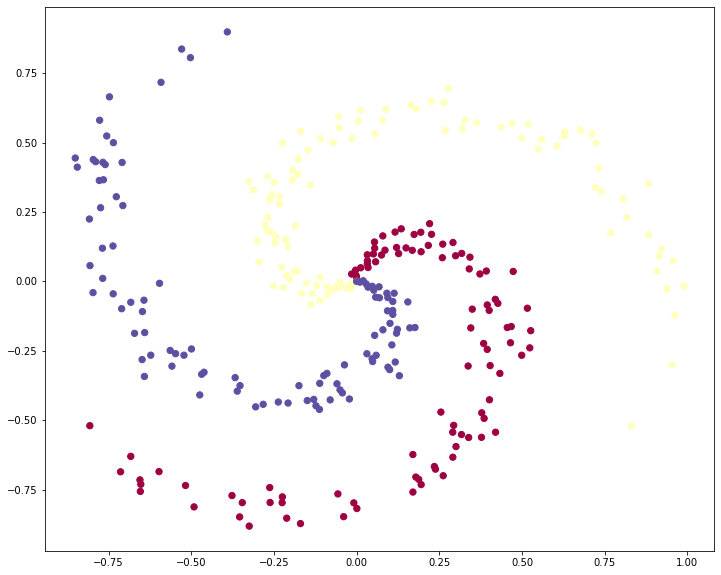

In [ ]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()

# Train a Linear Classifier

## Initialize the weights with random numbers

In [ ]:
W = 0.01 * np.random.randn(D,K)
b = np.zeros((1,K))
step_size = 1e-0
reg = 1e-3 

## Optimize the classifier using a basic gradient descent

In [ ]:
num_examples = X.shape[0]
for i in range(200):
  
  # evaluate class scores, [N x K]
  scores = np.dot(X, W) + b 
  
  # compute the class probabilities
  exp_scores = np.exp(scores)
  probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # [N x K]
  
  # compute the loss: average cross-entropy loss and regularization
  correct_logprobs = -np.log(probs[range(num_examples),y])
  data_loss = np.sum(correct_logprobs)/num_examples
  reg_loss = 0.5*reg*np.sum(W*W)
  loss = data_loss + reg_loss
  if i % 10 == 0:
    print("iteration %d: loss %f" % (i, loss))
  # Compute the gradient
  dscores = probs
  dscores[range(num_examples),y] -= 1
  dscores /= num_examples
  
  # backpropogate the gradient to the parameters (W,b)
  dW = np.dot(X.T, dscores)
  db = np.sum(dscores, axis=0, keepdims=True)
  
  dW += reg*W # regularization gradient
  
  # perform a parameter update
  W += -step_size * dW
  b += -step_size * db

iteration 0: loss 1.099287
iteration 10: loss 0.903380
iteration 20: loss 0.830699
iteration 30: loss 0.797708
iteration 40: loss 0.780508
iteration 50: loss 0.770680
iteration 60: loss 0.764698
iteration 70: loss 0.760888
iteration 80: loss 0.758377
iteration 90: loss 0.756679
iteration 100: loss 0.755506
iteration 110: loss 0.754683
iteration 120: loss 0.754097
iteration 130: loss 0.753676
iteration 140: loss 0.753371
iteration 150: loss 0.753147
iteration 160: loss 0.752983
iteration 170: loss 0.752861
iteration 180: loss 0.752771
iteration 190: loss 0.752703


## Evaluate the accuracy

In [ ]:
scores = np.dot(X, W) + b
predicted_class = np.argmax(scores, axis=1)
print('training accuracy: %.2f' % (np.mean(predicted_class == y)))
print(W.size)
print(b.size)

training accuracy: 0.53
6
3


## Plot the resulting classifier


(-1.881497286235014, 1.8785027137649892)

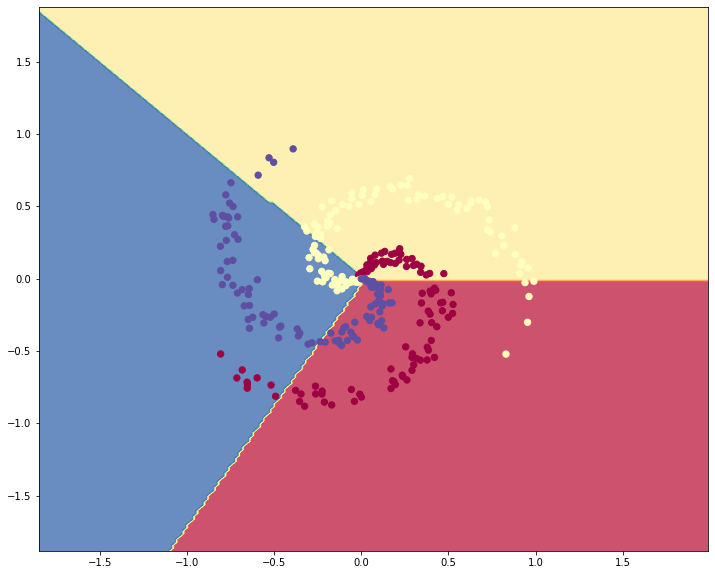

In [ ]:
h = 0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = np.dot(np.c_[xx.ravel(), yy.ravel()], W) + b
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)
fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

## Let's try again, and add a hidden layer
### We start by initializing the parameters

In [ ]:
h = 100 # size of hidden layer
W = 0.01 * np.random.randn(D,h)
b = np.zeros((1,h))
W2 = 0.01 * np.random.randn(h,K)
b2 = np.zeros((1,K))

step_size = 1e-0
reg = 1e-3 # regularization strength

# gradient descent loop
num_examples = X.shape[0]
for i in range(10000):
  
  # evaluate class scores, [N x K]
  hidden_layer = np.maximum(0, np.dot(X, W) + b) # note, ReLU activation
  scores = np.dot(hidden_layer, W2) + b2
  
  # compute the class probabilities
  exp_scores = np.exp(scores)
  probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # [N x K]
  
  # compute the loss: average cross-entropy loss and regularization
  correct_logprobs = -np.log(probs[range(num_examples),y])
  data_loss = np.sum(correct_logprobs)/num_examples
  reg_loss = 0.5*reg*np.sum(W*W) + 0.5*reg*np.sum(W2*W2)
  loss = data_loss + reg_loss
  if i % 1000 == 0:
    print("iteration %d: loss %f" % (i, loss))
  
  # compute the gradient on scores
  dscores = probs
  dscores[range(num_examples),y] -= 1
  dscores /= num_examples
  
  # backpropate the gradient to the parameters
  # first backprop into parameters W2 and b2
  dW2 = np.dot(hidden_layer.T, dscores)
  db2 = np.sum(dscores, axis=0, keepdims=True)
  # next backprop into hidden layer
  dhidden = np.dot(dscores, W2.T)
  # backprop the ReLU non-linearity
  dhidden[hidden_layer <= 0] = 0
  # finally into W,b
  dW = np.dot(X.T, dhidden)
  db = np.sum(dhidden, axis=0, keepdims=True)
  
  # add regularization gradient contribution
  dW2 += reg * W2
  dW += reg * W
  
  # perform a parameter update
  W += -step_size * dW
  b += -step_size * db
  W2 += -step_size * dW2
  b2 += -step_size * db2

iteration 0: loss 1.098600
iteration 1000: loss 0.295973
iteration 2000: loss 0.257762
iteration 3000: loss 0.252570
iteration 4000: loss 0.249985
iteration 5000: loss 0.249021
iteration 6000: loss 0.248598
iteration 7000: loss 0.248438
iteration 8000: loss 0.248305
iteration 9000: loss 0.248245


## Evaluate training set accuracy

In [ ]:
hidden_layer = np.maximum(0, np.dot(X, W) + b)
scores = np.dot(hidden_layer, W2) + b2
predicted_class = np.argmax(scores, axis=1)
print('training accuracy: %.2f' % (np.mean(predicted_class == y)))
print(b.size)
print(W.size)
print(b2.size)
print(W2.size)
print(dscores.size)

training accuracy: 0.98
100
200
3
300
900


### Plot the resulting classifier

(-1.881497286235014, 1.8785027137649892)

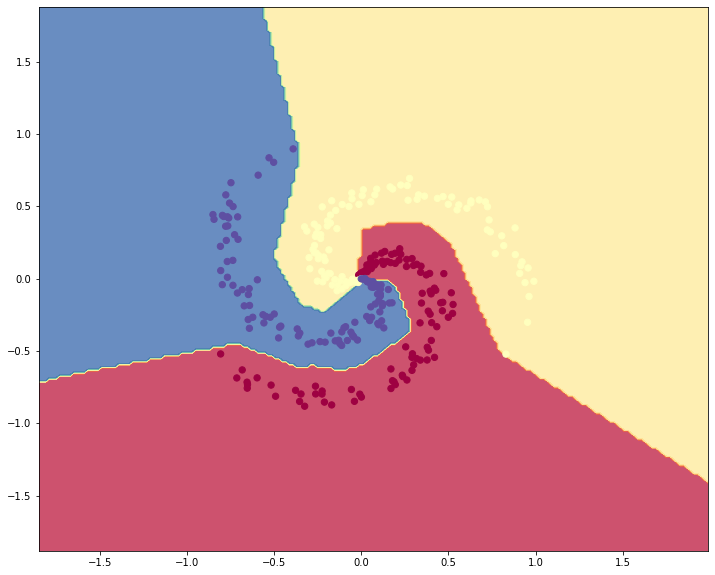

In [ ]:
h = 0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = np.dot(np.maximum(0, np.dot(np.c_[xx.ravel(), yy.ravel()], W) + b), W2) + b2
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)
fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

Hooray, with 603 parameters, we were able to fit the data.



# Introduction to SciPy

### SciPy has loads of useful 

 * scipy.io.matlab	–	support	for	Matlab	(.mat)	
 * scipy.io.loadmat()	and	scipy.io.savemat()	
 * Clustering	algorithms	(scipy.cluster)
 * Integration	and	ODEs	(scipy.integrate)
 * Interpolation	(scipy.interpolate)
 * Input	and	output	(scipy.io)
 * Linear	algebra	(scipy.linalg)
 * Muli-dimensional	image	processing	(scipy.ndimage)
 * Optimizaton	and	root	finding	(scipy.optimize)
 * Signal	processing	(scipy.signal)
 * Sparse	matrices	(scipy.sparse)
 * Spatial	algorithms	and	data	structures	(scipy.spatial)
 * Special	functions	(scipy.special)
 * Statstical	functions	(scipy.stats)



https://docs.scipy.org/doc/scipy/reference/tutorial/interpolate.html


1-D interpolation (interp1d)
The interp1d class in scipy.interpolate is a convenient method to create a function based on fixed data points, which can be evaluated anywhere within the domain defined by the given data using linear interpolation. An instance of this class is created by passing the 1-D vectors comprising the data. The instance of this class defines a __call__ method and can therefore by treated like a function which interpolates between known data values to obtain unknown values (it also has a docstring for help). Behavior at the boundary can be specified at instantiation time. The following example demonstrates its use, for linear and cubic spline interpolation:


In [ ]:
from scipy.interpolate import interp1d

x = np.linspace(0, 10, num=11, endpoint=True)
y = np.cos(-x**2/9.0)
f = interp1d(x, y)
f2 = interp1d(x, y, kind='cubic')

xnew = np.linspace(0, 10, num=41, endpoint=True)
import matplotlib.pyplot as plt
plt.plot(x, y, 'o', xnew, f(xnew), '-', xnew, f2(xnew), '--')
plt.legend(['data', 'linear', 'cubic'], loc='best')
plt.show()

Multivariate data interpolation (griddata)
Suppose you have multidimensional data, for instance, for an underlying function f(x, y) you only know the values at points (x[i], y[i]) that do not form a regular grid.

Suppose we want to interpolate the 2-D function

In [ ]:
def func(x, y):
  return x*(1-x)*np.cos(4*np.pi*x) * np.sin(4*np.pi*y**2)**2

## on a grid in [0, 1]x[0, 1]


In [ ]:
grid_x, grid_y = np.mgrid[0:1:100j, 0:1:200j]

### but we only know its values at 1000 data points:


In [ ]:
points = np.random.rand(1000, 2)
values = func(points[:,0], points[:,1])

### This can be done with the griddata function. Below, we try out all of the interpolation methods.

In [ ]:
from scipy.interpolate import griddata 
grid_z0 = griddata(points, values, (grid_x, grid_y), method='nearest') 
grid_z1 = griddata(points, values, (grid_x, grid_y), method='linear') 
grid_z2 = griddata(points, values, (grid_x, grid_y), method='cubic')

### One can see that the exact result is reproduced by all of the methods to some degree.

In [ ]:
import matplotlib.pyplot as plt
plt.subplot(221)
plt.imshow(func(grid_x, grid_y).T, extent=(0,1,0,1), origin='lower')
plt.plot(points[:,0], points[:,1], 'k.', ms=1)
plt.title('Original')
plt.subplot(222)
plt.imshow(grid_z0.T, extent=(0,1,0,1), origin='lower')
plt.title('Nearest')
plt.subplot(223)
plt.imshow(grid_z1.T, extent=(0,1,0,1), origin='lower')
plt.title('Linear')
plt.subplot(224)
plt.imshow(grid_z2.T, extent=(0,1,0,1), origin='lower')
plt.title('Cubic')
plt.gcf().set_size_inches(10, 10)
plt.show()

# Notebooks at MSI

Jupyter is more than an interface for teaching. Jupyter is heavily used by researchers. It's a great interface for research. MSI has a large cluster for running large-scale simulations and data anlysis. MSI also runs  JupyterHub to allow researchers to access thier data in a Jupyter environment. JupyterHub can be accessed here:

https://notebooks.msi.umn.edu

To use the notebooks at MSI, you will first need to select the group you want to work in. Most of you only have access to a single group. If you happen to be doing some research, you might have access to another group. After you select the group created for the class (csci5980) and press continue, you can click a button that reads "Start My Server". This will bring you to a dropdown menu to select the resources you need.

You can select the one labeled "Mesabi - 2 Cores, 4 GB, 8 hours". This will submit a job to the cluster and reserve the described resources for your Jupyter session.

JupyterHub at MSI is being upgraded over the next few weeks, so there will be some changes and outages to the interface. Expect email with updates!